## keras 버전 확인

In [1]:
import keras
keras.__version__

ModuleNotFoundError: No module named 'keras'

## gpu 설정

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16719349490352075143
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 113704122441978194
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [4]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## VAE 인코더 네트워크

In [5]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1) # 이미지는 28x28
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, 
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

## 잠재공간 sampling 함수

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
#    print("K.eval(z_mean):", K.eval(z_mean))
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

## 잠재공간 포인트를 이미지로 맵핑하는 VAE 디코더 네트워크

In [7]:
# Input에 z를 주입합니다
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

## VAE 손실을 계산하기 위해 직접 만든 층

In [8]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])

## z value 리턴받기

In [9]:
def z_value(z_mean, z_log_var):
    return tf.reduce_mean(z_mean)

#model.compile(optimizer='sgd',
#          loss='binary_crossentropy',
#          metrics=['accuracy', mean_pred])
#%%

## VAE 훈련하기

In [10]:
from keras.datasets import mnist

vae = Model(input_img, y)
#vae.compile(optimizer='rmsprop', loss=None, metrics=[z_value])
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# MNIST 숫자 이미지에서 VAE를 훈련합니다
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

hist = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=2,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 94s 2ms/sample - loss: 0.2656 - val_loss: 0.1994
Epoch 2/2
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1928 - val_loss: 0.1921


## z 값 찍어보기

In [11]:
#from keras.models import Model
layer_outputs = [layer.output for layer in [vae.get_layer("dense_1"), vae.get_layer("dense_2")] ]
# 입력에 대해 z_mean(dense_1), z_log_var(dense_2)층의 출력을 반환하는 모델을 만듭니다:
activation_model = Model(inputs=vae.input, outputs=layer_outputs)
out = activation_model.predict(np.reshape(x_test[0], ((1,) + x_test[0].shape)))
print(out)

[array([[-3.1576135,  1.6415263]], dtype=float32), array([[-2.021278 , -2.6946142]], dtype=float32)]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [15]:
out = activation_model.predict(np.reshape(x_test[1], ((1,) + x_test[0].shape)))
print(out)

[array([[-0.17055649, -0.8781807 ]], dtype=float32), array([[-3.3393414, -3.2327254]], dtype=float32)]


In [12]:
%whos

Variable                  Type          Data/Info
-------------------------------------------------
CustomVariationalLayer    type          <class '__main__.CustomVariationalLayer'>
K                         module        <module 'keras.backend' f<...>ckages/keras/backend.py'>
Model                     type          <class 'keras.engine.training.Model'>
activation_model          Functional    <keras.engine.functional.<...>object at 0x7fece25fc710>
batch_size                int           16
decoder                   Functional    <keras.engine.functional.<...>object at 0x7fedc033d550>
decoder_input             Tensor        Tensor("input_2:0", shape=(?, 2), dtype=float32)
device_lib                module        <module 'tensorflow.pytho<...>on/client/device_lib.py'>
hist                      History       <keras.callbacks.History <...>object at 0x7fedc02c16d0>
img_shape                 tuple         n=3
input_img                 Tensor        Tensor("input_1:0", shape<...>8, 28, 1), dty

## 2D 잠재공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기

# 새 섹션

In [13]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


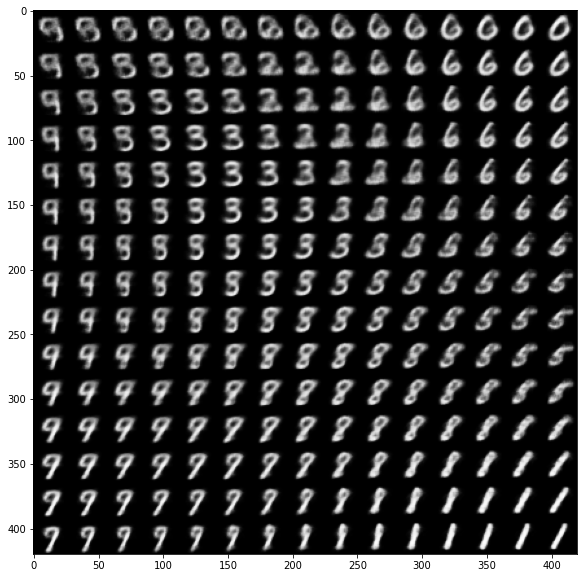

In [14]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()